# **LAB SESSION 2 - Bagging and Random Forests**

## Utils

*Note: in all this project, use **the value 0** when you need to choose a value for a random state*

In [1]:
import numpy as np
import pandas as pd # data analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

## Ex 1: comparison between random forests and bagging

We work with the [Urban Land Cover data base](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover). The data are used for automated mapping of urban land cover (trees, grass, soil, concrete, asphalt, buildings, etc.) in satellite or aerial imagery. Nine types of urban land cover are considered and multi-scale spectral, size, shape, and texture information are used for classification. The data consists in a train set and a test set. **The goal is to predict the urban land cover (the variable named `class`) based on the multi-scale spectral, size, shape, and texture information. It is then a classification problem. We will use the overall accuracy (1-misclassification rate) as performance criterion**. Note that other preformnce criterion exist for classification problem such as specificity, sensitivity, F-score, etc.

Before to start, we: 
 1) load the data and perform a brief descriptive analysis of them;
 2) select the variables that we will use in the exercise, 


In [2]:
# Load the data 
ulc_train = pd.read_csv("ULC_training.csv") 
ulc_test = pd.read_csv("ULC_testing.csv") 

In [3]:
# Display the dimension
print(ulc_train.shape)
print(ulc_test.shape)

(168, 148)
(507, 148)


In [4]:
# Have a first quick look at the datasets and display the dimension
ulc_train.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38


In [5]:
ulc_test.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,concrete,1.32,131,0.81,222.74,1.66,2.18,192.94,235.11,240.15,...,31.15,5.04,0.80,0.58,8.56,0.82,0.98,-0.10,1512,1287.52
1,shadow,1.59,864,0.94,47.56,1.41,1.87,36.82,48.78,57.09,...,12.01,3.70,0.52,0.96,7.01,1.69,0.86,-0.14,196,2659.74
2,shadow,1.41,409,1.00,51.38,1.37,1.53,41.72,51.96,60.48,...,18.75,3.09,0.90,0.63,8.32,1.38,0.84,0.10,1198,720.38
3,tree,2.58,187,1.91,70.08,3.41,3.11,93.13,55.20,61.92,...,27.67,6.33,0.89,0.70,8.56,1.10,0.96,0.20,524,891.36
4,asphalt,2.60,116,2.05,89.57,3.06,3.02,73.17,94.89,100.64,...,32.05,1.01,0.83,0.75,8.62,2.08,0.08,-0.10,496,1194.76


In [6]:
## Display a statistic summary for the numerical variables
ulc_train.describe(include='all')

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,...,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.008512,565.869048,1.132976,165.569821,2.077679,2.229881,161.577083,163.672440,171.459226,...,23.769881,3.098274,0.796488,0.665000,7.795536,1.594405,0.615357,0.014583,983.309524,1275.292917
std,NaN,0.634807,679.852886,0.489150,61.883993,0.699600,0.703572,63.407201,71.306748,67.973969,...,12.836522,6.101883,0.103930,0.179086,0.670491,0.460627,0.239900,0.153677,880.013745,603.658611
min,NaN,1.000000,10.000000,0.020000,37.670000,1.000000,1.060000,30.680000,32.210000,40.120000,...,4.020000,1.000000,0.330000,0.240000,6.290000,0.230000,0.070000,-0.360000,56.000000,336.730000
25%,NaN,1.537500,178.000000,0.787500,133.977500,1.547500,1.700000,91.040000,101.187500,120.165000,...,13.965000,1.395000,0.757500,0.560000,7.357500,1.325000,0.460000,-0.080000,320.000000,817.405000
50%,NaN,1.920000,315.000000,1.085000,164.485000,1.940000,2.130000,187.560000,160.615000,178.345000,...,21.135000,1.740000,0.810000,0.690000,7.790000,1.660000,0.620000,-0.040000,776.000000,1187.025000
75%,NaN,2.375000,667.000000,1.410000,221.895000,2.460000,2.680000,210.940000,234.815000,236.002500,...,29.957500,2.285000,0.870000,0.810000,8.260000,1.945000,0.810000,0.120000,1412.500000,1588.427500


In [7]:
ulc_test.describe(include='all')

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,507,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,...,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,building,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.025720,562.504931,1.237574,165.612939,2.187081,2.277318,166.290355,162.291953,168.256667,...,24.601144,2.931657,0.817712,0.597732,8.048698,1.455838,0.653905,0.027436,1398.706114,1101.998185
std,NaN,0.619254,698.655240,0.561988,63.230806,0.874054,0.718441,59.217648,73.455101,69.702475,...,12.203441,4.942887,0.106007,0.197505,0.787912,0.451781,0.251287,0.133834,1097.323462,533.927869
min,NaN,1.000000,22.000000,0.000000,26.850000,1.000000,1.040000,22.910000,26.520000,31.110000,...,2.650000,1.000000,0.200000,0.100000,5.690000,0.240000,0.030000,-0.360000,34.000000,211.270000
25%,NaN,1.580000,159.000000,0.840000,127.485000,1.650000,1.715000,146.460000,97.585000,111.715000,...,14.485000,1.375000,0.770000,0.455000,7.370000,1.160000,0.470000,-0.080000,601.000000,726.745000
50%,NaN,1.950000,323.000000,1.210000,170.650000,2.000000,2.180000,189.630000,158.280000,167.750000,...,22.380000,1.920000,0.840000,0.610000,8.020000,1.440000,0.710000,-0.020000,1148.000000,1011.230000
75%,NaN,2.380000,681.500000,1.565000,224.825000,2.490000,2.675000,206.780000,237.375000,238.480000,...,33.825000,2.800000,0.890000,0.760000,8.750000,1.775000,0.860000,0.145000,1874.000000,1335.640000


In [8]:
## Display the distribution of the target variable in the two datasets
ulc_train['class'].value_counts()


class
grass        29
building     25
concrete     23
tree         17
shadow       16
car          15
pool         15
asphalt      14
soil         14
Name: count, dtype: int64

In [9]:
ulc_test['class'].value_counts()

class
building     97
concrete     93
tree         89
grass        83
shadow       45
asphalt      45
car          21
soil         20
pool         14
Name: count, dtype: int64

In [10]:
# Select the variables that we be used 
target_column = "class" # The response variable that we will consider
features_columns = list(ulc_train)
features_columns.remove('class') # The predictors/features used to predict the target
#print(target_column)
#print(features_columns)

In [11]:
data, target = ulc_train[features_columns], ulc_train[target_column]
data_test, target_test = ulc_test[features_columns], ulc_test[target_column]

**Question 1. Fit a random forest named *`rfc`* on the train set to explain the type of urban land cover (variable `class`) according to multi-scale spectral, size, shape, and texture information. More specifically, you will use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class or [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) class. Read carefully the documentation and choose between the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class or [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) class. Before buiding *`rfc`* remind in the window below the meaning of`n_estimators` and `max_features`.**

**For the hyperparameters, use the values `n_estimators = 500` and `max_features= sqrt(d)` with `d` denoting the number of features, `oob_score=True`  and`rando_state=0`.**


Your answer:  
n_estimators is the number of decision tree classifiers to be created from the data   
max_features is the number of features selected at each split

In [12]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: create the object rfc, it is a RandomForestClassifier object with n_estimators=500, max_features='auto' and random_state=0
rfc = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=0, oob_score=True)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
rfc.fit(data, target)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


randomness is fixed because at bootstraping level in RF randomly selects the sample to use in the trees an dalso when splitting wthere is randomo selection of feature variables to use.

In [13]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 3: look at the parameters used by your forest
print('Parameters of the forest:\n')
pprint(rfc.get_params())

Parameters of the forest:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


**Compute the oob error and comment the result. What does it represent ?**

In [14]:
# Step 4: print the OOB error
print('OOB error: ',  1 - rfc.oob_score_)

OOB error:  0.15476190476190477


**Meaning of the OOB error and result interpretation:**

Answer:  
The OOB error is the prediction error of each tree given the observations not picked during bootsraping used to train all trees. The OOB error is 0.1548 meaning the model has miscallisfied 15% of the OOB observation.   
The OOB error is optimitsic compared to the test set because the samples are more similar to train, however they can be almost similar depending on the problem.

**Question 2. Predict the class of each observation of the test sample by using the random forest `rfc`and display the confusion matrix. Comment it. How many observations are misclassified ? Compute the accuracy.**

0.81


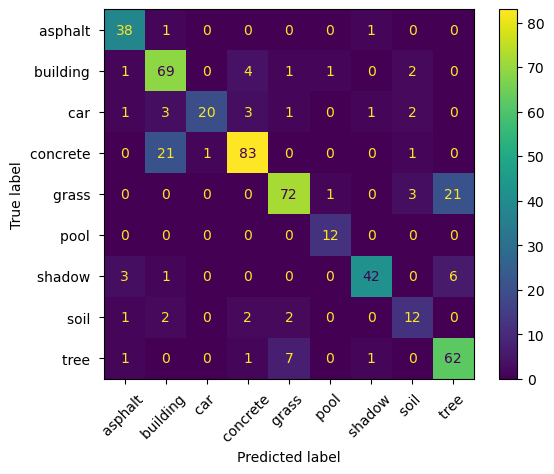

In [15]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: compute the predictions on the test set2
predictions_test = rfc.predict(data_test) 

# Step 2: display the confusion matrix on the test set
cm = confusion_matrix(predictions_test, target_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot() 
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(),rotation=45) #xlabels aesthetics

# Step 3: compute the accuracy on the test set
accuracy = rfc.score(data_test, target_test)
print(round(accuracy,2))


Comment:   
The model has an accuracy score of 0.8 meaning it predicted correctly 80% of the samples. However we notice that some classes have misclassified samples some more some not so significant, for example, concrete label with 21 of 109 samples miscalssified as building and asphalt label with 3 out of 42 misclassified as shadow. 

In [16]:
# misclassified observations
num_misclassified = (predictions_test != target_test).sum()
print('Number of misclassified observations in the test set:', num_misclassified)

Number of misclassified observations in the test set: 97


**Question 3. We will now focus on the calibration of some RF parameters: `n_estimators` and `max_features`. To calibrate these parameters, we will used the OOB errors. The code below shows how the OOB error can be measured at the addition of each new tree during training. The resulting plot can be used to approximate a suitable value of `n_estimators` at which the OOB error stabilizes. Comment this plot. What value for `n_estimators` does it seem suitable ?**

*Indication: a suitable value for `n_estimators` is a value for which the oob error of the forest is stable.*


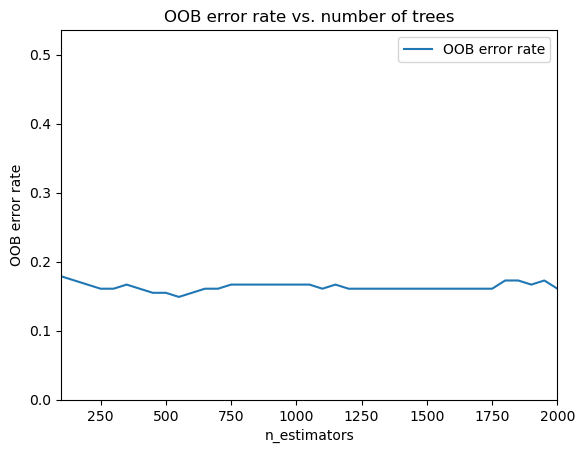

In [17]:
RANDOM_STATE = 0


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = []

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step=50

for i in range(min_estimators, max_estimators+1, step):
    rf = RandomForestClassifier(warm_start=True, n_estimators=i, max_features='sqrt',random_state=RANDOM_STATE, oob_score=True)
    rf.fit(data, target)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate.append(oob_error)
  

# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0, 3*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs. number of trees") 
plt.legend(loc="upper right")
plt.show()


Comment of the plot and choice of a suitable value for `n_estimators`:   
The OOB error initially drops, then increases and is kinda level after some time as the number of models increase. The suitable value of the n_estimators would be around 500 in this context to ensure balance in model performance and computaion efficiency.  
*Choose n_estimators when oob error is more stabilized.

**Question 4. Now, we will repeat `B` times a `k`-fold cross validation with the function GridSearchCV to calibrate the parameter `max_features`. Complete the command below, comment the results and select suitable value for `max_features`. For `n_estimators`use the value previously selected.**

**Indications:**
- **Consider the following values`max_features = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)`. The values (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) for `max_features` represent the proportions of selected features. See the documention of [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class.**
- **we will repeat `B=10`times a k-fold crossvalidation with `k=3`.**

In [18]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: create a grid with all the values that we will considers for the two paramters
grid = {
    'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
}

# Step 2: use the grid to to search for the best couple of parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
rf = RandomForestClassifier(n_estimators=100, random_state=0,n_jobs=-1) # create the forest model to tune

B=10
cv_split = RepeatedKFold(n_splits=3, n_repeats=B, random_state=RANDOM_STATE)
rf_cv = GridSearchCV(estimator=rf, param_grid=grid, cv=cv_split, n_jobs=-1)
rf_cv.fit(data, target) # Fit the CV search

# Step 3: get the best parameters (with the higher performance)
# print(rf_cv.cv_results_)

df = pd.DataFrame(rf_cv.cv_results_) # Convert cv_results_ to a DataFrame
df


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.295199,0.053413,0.062401,0.016828,0.1,{'max_features': 0.1},0.767857,0.803571,0.803571,0.803571,...,0.875000,0.821429,0.750000,0.839286,0.821429,0.821429,0.767857,0.809524,0.033034,6
1,0.334826,0.049648,0.085838,0.021196,0.2,{'max_features': 0.2},0.767857,0.803571,0.839286,0.803571,...,0.857143,0.821429,0.696429,0.875000,0.803571,0.875000,0.767857,0.809524,0.038941,7
2,0.373839,0.066391,0.121415,0.041429,0.3,{'max_features': 0.3},0.785714,0.803571,0.839286,0.821429,...,0.839286,0.803571,0.767857,0.875000,0.839286,0.857143,0.821429,0.815476,0.032055,1
3,0.415638,0.080845,0.140056,0.042622,0.4,{'max_features': 0.4},0.785714,0.839286,0.857143,0.821429,...,0.875000,0.803571,0.732143,0.839286,0.821429,0.875000,0.821429,0.814881,0.037025,2
4,0.430519,0.079927,0.179403,0.070967,0.5,{'max_features': 0.5},0.767857,0.839286,0.857143,0.821429,...,0.839286,0.803571,0.750000,0.803571,0.803571,0.857143,0.803571,0.812500,0.033487,4
5,0.468047,0.085870,0.189380,0.070568,0.6,{'max_features': 0.6},0.803571,0.857143,0.857143,0.803571,...,0.857143,0.803571,0.750000,0.857143,0.821429,0.857143,0.839286,0.814881,0.037311,2
6,0.527080,0.109148,0.215859,0.087604,0.7,{'max_features': 0.7},0.785714,0.839286,0.839286,0.821429,...,0.875000,0.785714,0.750000,0.803571,0.803571,0.875000,0.821429,0.812500,0.040655,4
7,0.567557,0.120846,0.241275,0.091661,0.8,{'max_features': 0.8},0.803571,0.857143,0.857143,0.857143,...,0.839286,0.750000,0.732143,0.821429,0.803571,0.857143,0.821429,0.807143,0.042358,8
8,0.544877,0.106419,0.244296,0.114361,0.9,{'max_features': 0.9},0.803571,0.839286,0.821429,0.821429,...,0.839286,0.714286,0.750000,0.839286,0.803571,0.857143,0.803571,0.806548,0.038599,9


looking at the values as is we can see that the mean sores using only 2dp because our train data is only 100 and are (0.81,0.81,0.82,0.81,0.81,0.81,0.81,0.81,0.81,0.81). The results are quite stable and the chnage is not to big we go with 0.3

In [19]:
print("Best parameters:", rf_cv.best_params_)
print("Best cross-validated score:", rf_cv.best_score_)

Best parameters: {'max_features': 0.3}
Best cross-validated score: 0.8154761904761905


Result interpretation and choice of tuned value for  `max_features`:  
The results are such that you get the test score for each split (K*B=30) and the average. Given the mean mean test score the best max_features is 0.3 with the highest value at 0.155.

**Question 5. Now, replace the value of `max_features`by the one that you selected at the previous question and check again the optimal value of `n_estimators` when using the optimal value for `max_features`. Comment your result. What value for `n_estimators`do you finally choose ?**

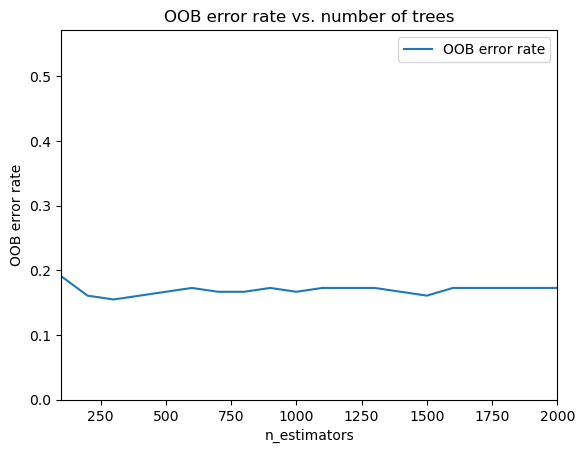

In [20]:
##------- Complete the command below by filling in the gaps '...'.-------##
RANDOM_STATE = 0 # Note: if you modifiy the random stat, the results can be sligthly different


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = []

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step=100

for i in range(min_estimators, max_estimators+1, step):
    rf = RandomForestClassifier(warm_start=True, n_estimators=i, max_features=0.3,random_state=RANDOM_STATE, oob_score=True)
    rf.fit(data, target)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate.append(oob_error)
  

# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0, 3*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

comment:  
Given the chart above the best `n_estimators` would be about 300 as it has the lowest error rate.

**Question 6. Build the random forest `opt_rfc` by using the best values for the parameters `n_estimators` and `max_features`. Compute the accuracy on the test set and display the confusion matrix.** 

Accuracy in opt_rfc:  0.81


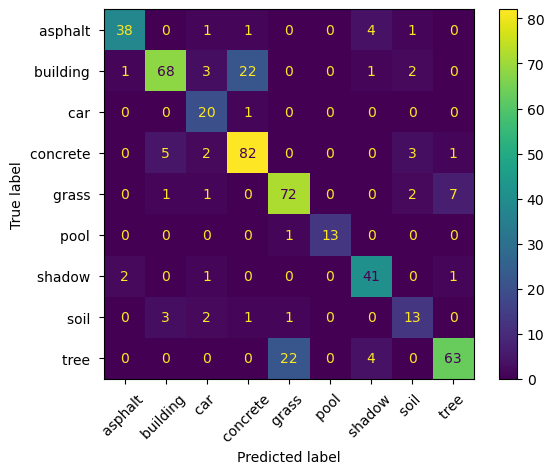

In [21]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: fit a random forest with the best values for parameters
opt_rfc = RandomForestClassifier(n_estimators=300, max_features=0.3,oob_score=True,random_state=0)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
opt_rfc.fit(data, target)

# Step 3: compute the accuracy and the confusion matrix
predictions_test_2 = opt_rfc.predict(data_test) 
cm_2 = confusion_matrix(target_test, predictions_test_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2,display_labels=opt_rfc.classes_)
disp.plot() 
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(),rotation=45) #xlabels aesthetics

# Step 4: compute the accuracy
accuracy_2 = opt_rfc.score(data_test, target_test)
print('Accuracy in opt_rfc: ',round(accuracy_2,2))

**Question 7. what value for`max_features` we have to choose if we want to apply the bagging algorithm with CART instead of a random forest ? Build this model and compute the prediction error of this model based on the test set. We will call this model $bag$.**

**Indication: use the value selected previously for the parameter `n_estimators`.** 

Bagging builds multiple CART trees on bootstrapped datasets using all features, while Random Forest adds randomness by selecting a random subset of features at each split, reducing tree correlation and improving generalization.

0.81


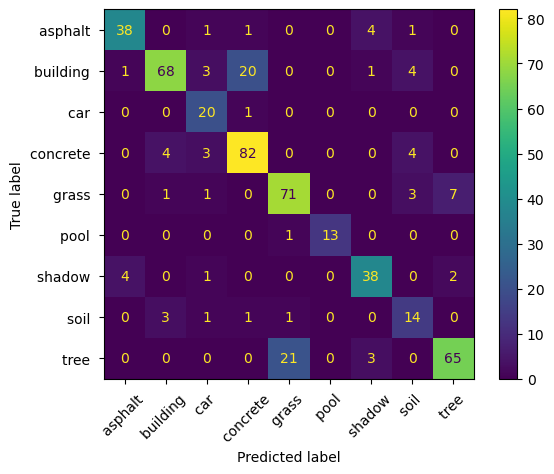

In [22]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: fit a a bagging model (use the best value for n_estimators)
# if max_features=None, then max_features=n_features
bag = RandomForestClassifier(n_estimators=300, max_features=None,oob_score=True,random_state=0)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
bag.fit(data, target)

# Step 3: compute the prediction on the test set and the confusion matrix
predictions_test_bag = bag.predict(data_test) 
cm_bag = confusion_matrix(target_test, predictions_test_bag)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bag,display_labels=bag.classes_)
disp.plot() 
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(),rotation=45) #xlabels aesthetics

# Step 4: compute the accuracy on the test set
accuracy_bag = bag.score(data_test, target_test)
print(round(accuracy_bag,2))

**Question 8. Fit a maximal CART tree on the training set using the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class, like in the first lab session. Next, compute the prediction error of this tree based on the test set. Name this tree `single_tree`.**

**Indication: to get the maximal tree, use `max_depth=None` (the default value).**

In [23]:
# fit maximal CART tree
from sklearn.tree import DecisionTreeClassifier

single_tree = DecisionTreeClassifier(max_depth=None, random_state=0)
single_tree.fit(data, target)

# accuracy
accuracy_single_tree = single_tree.score(data_test, target_test)

**Question 9. Compare your three models `opt_rfc`, `bag`and `single_tree` using suitable performance criteria. What model do you choose and why ?**

In [34]:
# compare accuracies for opt_rfc, bag and single_tree
print('Accuracy in opt_rfc: ', round(accuracy_2, 2))
print('Accuracy in bag: ', round(accuracy_bag, 2))
print('Accuracy in single_tree: ', round(accuracy_single_tree, 2))

# accuracy per classes
from sklearn.metrics import recall_score, f1_score

recall_opt_rfc = recall_score(target_test, predictions_test_2, average='macro')
recall_bag = recall_score(target_test, predictions_test_bag, average='macro')
predict_singletree = single_tree.predict(data_test)
recall_single_tree = recall_score(target_test, predict_singletree, average='macro')

f1_opt_rfc = f1_score(target_test, predictions_test_2, average='macro')
f1_bag = f1_score(target_test, predictions_test_bag, average='macro')
f1_single_tree = f1_score(target_test, predict_singletree, average='macro')

print('Recall per class in opt_rfc: ', np.round(recall_opt_rfc, 2))
print('Recall per class in bag: ', np.round(recall_bag, 2))
print('Recall per class in single_tree: ', np.round(recall_single_tree, 2))

print('F1 score per class in opt_rfc: ', np.round(f1_opt_rfc, 2))
print('F1 score per class in bag: ', np.round(f1_bag, 2))
print('F1 score per class in single_tree: ', np.round(f1_single_tree, 2))

Accuracy in opt_rfc:  0.81
Accuracy in bag:  0.81
Accuracy in single_tree:  0.72
Recall per class in opt_rfc:  0.83
Recall per class in bag:  0.83
Recall per class in single_tree:  0.74
F1 score per class in opt_rfc:  0.81
F1 score per class in bag:  0.81
F1 score per class in single_tree:  0.72


Your Answer:   
The single tree performs the worst of the models with the lowest values across the metrics computed. The optimized random forest and recall are neck and neck however the optimized random forest has a slight advantage and i think it accounts for the simimlarities in the decision trees given the features.  
model chosen: optimized random forest

**Question 10. The MDA of each of the 147 features in the dataset has been independently computed `n__repeats` times on the test set (using each time another permutation of each feature). The code below shows the boxplot of the mean decrease in accuracy (MDA) for the 15 features with the highest average MDA.Comment the plot.** 

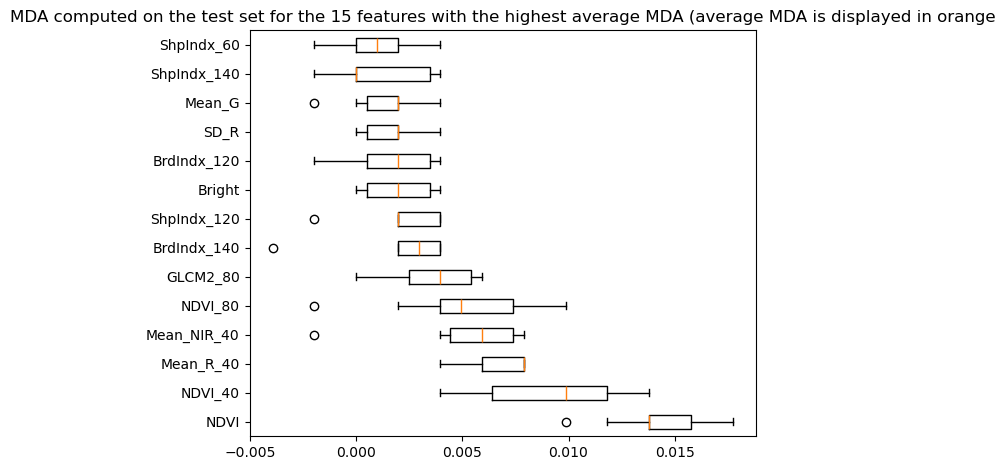

In [25]:
## Computation of the MDA for all features
from sklearn.inspection import permutation_importance
result = permutation_importance(opt_rfc, data_test, target_test, n_repeats=10, random_state=0, n_jobs=2)

## Plot of the MDA for the 15 features with the highest average MDA
sorted_idx = result.importances_mean.argsort() # features sorted from least important to most important
invert_sorted_idx=sorted_idx[::-1][:14]# keep only the 15 features with the highest average MDA

fig, ax = plt.subplots()
ax.boxplot(result.importances[invert_sorted_idx].T, vert=False, tick_labels=data_test.columns[invert_sorted_idx])
ax.set_title("MDA computed on the test set for the 15 features with the highest average MDA (average MDA is displayed in orange")
fig.tight_layout()
plt.show()

Solution for the comments about the plot:  
Most important feature is NDVI because it has the highest MDA of the 15 features. This means shuffling NDVI causes a higher decrease in accuracy compared to say ShpIndx_60 hence NDVI contribution is very high in the model.

**Question 11. What importance index is stored in `opt_rfc.feature_importances_` ? Use the Python documentation [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to answer.**   
Comments about the plot above: .......

In [26]:
# opt_rfc.feature_importances_
feat_importances = pd.Series(opt_rfc.feature_importances_, index=features_columns)
feat_importances.sort_values(ascending=False)

NDVI          0.076676
NDVI_40       0.071658
NDVI_60       0.041570
NDVI_80       0.034459
Bright_100    0.026490
                ...   
Assym_40      0.000464
GLCM1_120     0.000451
Assym_60      0.000435
Compact_80    0.000392
Rect_140      0.000359
Length: 147, dtype: float64

Answer:  
MDI = the feature_importances returns the sum of all the impurity reductions caused by the feature across the whole decision trees.  
Not recommended because if you use different criterion wou will get different results

**Question 12. The code below plot the 30 features with the highest values in `feature_importances_` . Comment the plot and compare with the boxplots in Question 10.** 

<BarContainer object of 15 artists>

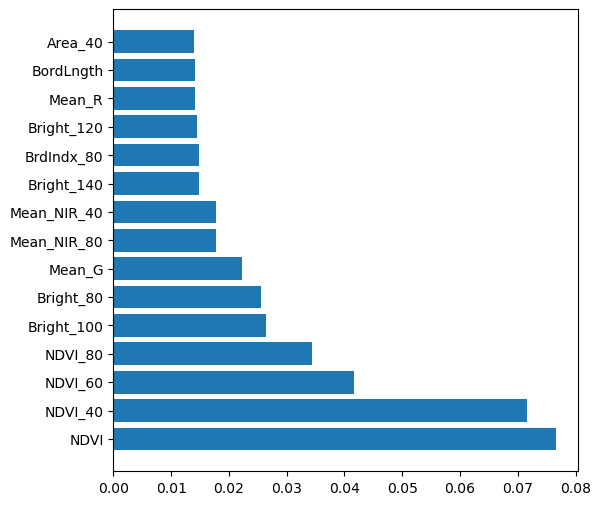

In [27]:
sorted_idx2 = opt_rfc.feature_importances_.argsort()
invert_sorted_idx2=sorted_idx2[::-1][:15]# keep only the 15 features with the highest average MDA
fig = plt.figure(figsize=(6,6))
plt.barh(data.columns[invert_sorted_idx2], opt_rfc.feature_importances_[invert_sorted_idx2])

Answer:  
The bar chart and box plot both show NDVI as the most important feature, however the rest of the fetaures defer . The MDA box plot shows the important features based on the impact on prediction accuracy while the feature_importances_ bar chart shows important features based on the decrease in gini impurity. 

## Ex 2: discover several variable selection methods

Here, we keep working with the urban dataset.

**Questions:**
 - 1) **Based on the end of the exercice select a subset of variable and build a new random forest based only the selected subset of features. Justify your choice.**
 - 2) **Apply the function `RFE` from `sklearn.feature_selection` that implement the RFE algorithm and select the best size of subset. Use MDA for the importance measure. Build a new random forest based on the selected subset.**
 - 3) **Apply now the boruta algorithm using the function `BorutaPy`from `boruta`. Don't select a size for the subest of selected features, the size will be determined automatically by the function. Then, build a random forest based on the selected subset.**
 - 4) **Compare all models. What model do you select and why?**
 
 
**Justify all your choices.**

In [28]:
# variable subset based on feature_importances_
features_subset = data.columns[invert_sorted_idx2[:14]] 

# fit rf model
rfc1 = RandomForestClassifier(n_estimators=300, random_state=0, max_features=0.3, oob_score=True)
rfc1.fit(data[features_subset], target)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [29]:
from sklearn.feature_selection import RFE

selector = RFE(rfc, n_features_to_select=15, step=1)
selector = selector.fit(data, target)

# fit new rf model based on selected features
rfc2 = RandomForestClassifier(n_estimators=300, random_state=0, max_features=0.3, oob_score=True)
rfc2.fit(data[data.columns[selector.support_]], target)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


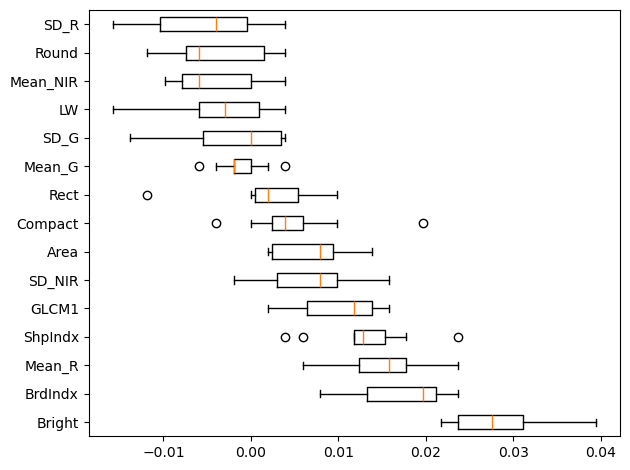

In [30]:
results = permutation_importance(rfc2, 
                                 data_test[data.columns[selector.support_]], 
                                 target_test, n_repeats=10, random_state=0, n_jobs=2)

## Plot of the MDA for the features with the highest average MDA
sorted_idx = results.importances_mean.argsort()[::-1]

fig, ax = plt.subplots()
ax.boxplot(results.importances[sorted_idx].T, vert=False, tick_labels=data_test.columns[sorted_idx])
fig.tight_layout()
plt.show()

In [31]:
from boruta import BorutaPy

boruta_selector = BorutaPy(estimator = rfc, n_estimators='auto', random_state=0)
boruta_selector = boruta_selector.fit(np.array(data), np.array(target))

# fit rf model
rfc3 = RandomForestClassifier(n_estimators=300, random_state=0, max_features=0.3, oob_score=True)
rfc3.fit(data[data.columns[boruta_selector.support_]], target)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [32]:
# compare the three models 
subset1 = rfc1.score(data_test[features_subset], target_test)
subset_rfe = rfc2.score(data_test[data.columns[selector.support_]], target_test)
subset_boruta = rfc3.score(data_test[data.columns[boruta_selector.support_]], target_test)

print('Accuracy in rfc1 : ', round(subset1, 3))
print('Accuracy in rfc2 (RFE subset): ', round(subset_rfe, 3))
print('Accuracy in rfc3 (Boruta subset): ', round(subset_boruta, 3))

Accuracy in rfc1 :  0.791
Accuracy in rfc2 (RFE subset):  0.789
Accuracy in rfc3 (Boruta subset):  0.811
